<a href="https://colab.research.google.com/github/svetaepc/NLP-PyTorch/blob/master/text_classification_with_bert_and_pytorch_lightning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

import warnings

warnings.filterwarnings("ignore")

In [1]:
!pip install pytorch-lightning==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 kB 38.1 MB/s eta 0:00:00


In [5]:
# !pip install -q test_tube transformers pytorch-nlp pytorch-lightning==0.9.0


# Try installing this version

# !pip install pytorch-lightning==1.2.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 kB 34.1 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 0.9.0
    Uninstalling pytorch-lightning-0.9.0:
      Successfully uninstalled pytorch-lightning-0.9.0


In [2]:
# !pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 35.1 MB/s eta 0:00:00


In [2]:
!pip install numpy==1.23.5 # !!!!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.22.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
xarray 2024.9.0 requires numpy>=1.24, but you have numpy 1.23.5 which i

In [2]:
import pandas as pd
import numpy as np
# np.object = np.object_
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 42
INFO:lightning:Global seed set to 42


42

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
100% 68.8M/68.8M [00:01<00:00, 49.2MB/s]


In [4]:
df = pd.read_csv("toxic_comments.csv")
df.sample(7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
131631,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
125326,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
111256,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
83590,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0
37546,64479b84de1d00c1,", 9 October 2007 (UTC)\n\nP.s, the delta funct...",0,0,0,0,0,0
98371,0e3561a3ab12ebee,"]]- 10 September 1910, [[[Couvet]] )",0,0,0,0,0,0


In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

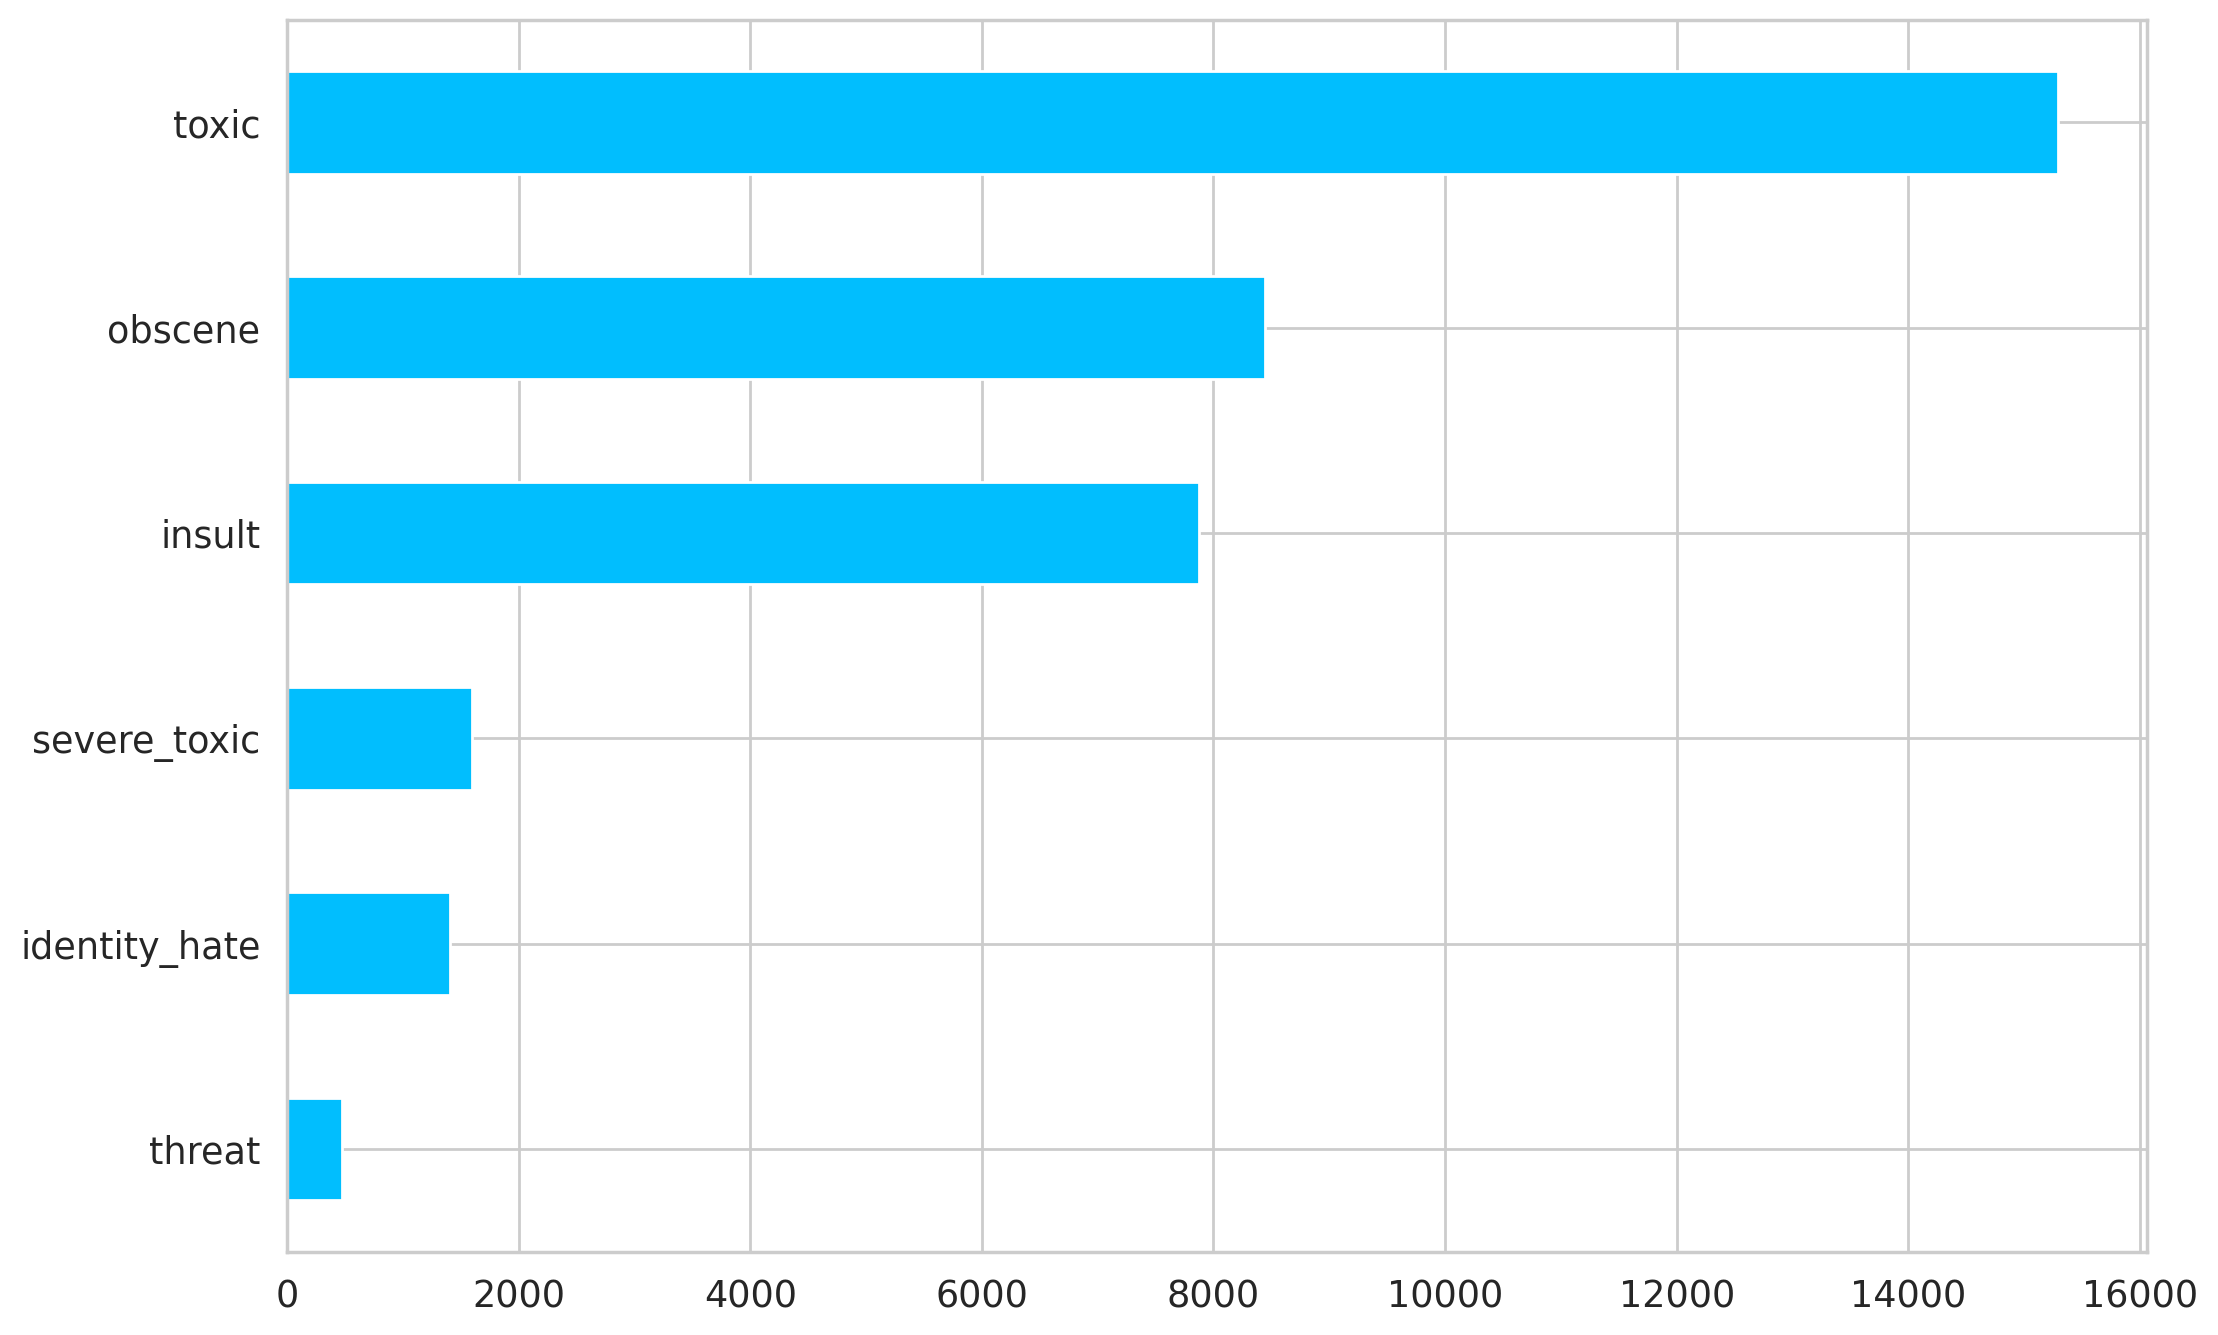

In [7]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

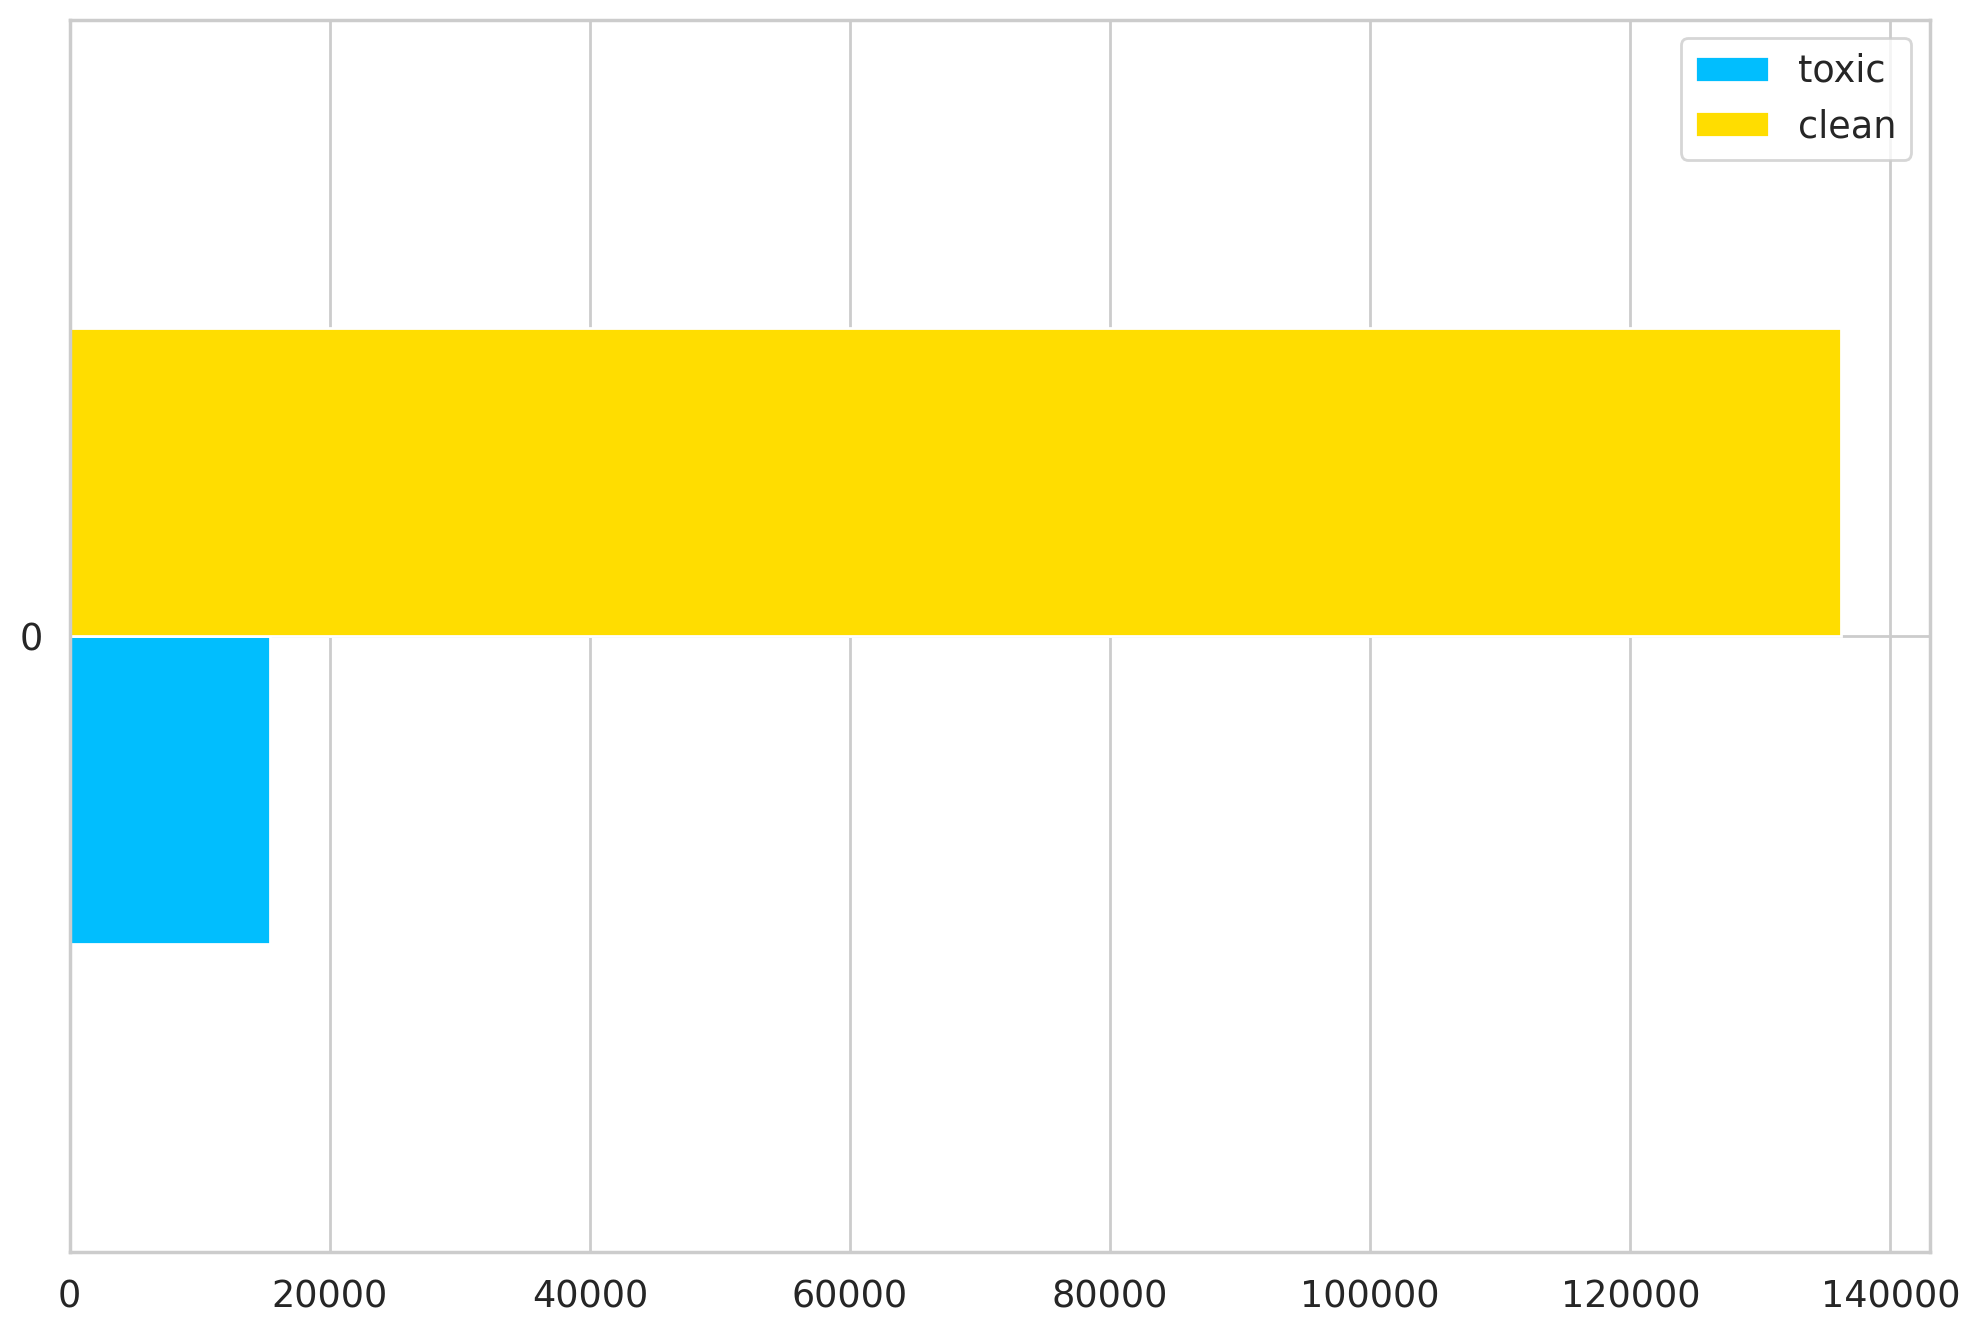

In [8]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  toxic=[len(train_toxic)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [9]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])
train_df.shape, val_df.shape

((30389, 8), (7979, 8))

In [10]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_comment)
print()
print(sample_labels.to_dict())

Bye! 

Don't look, come or think of comming back! Tosser.

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [12]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [14]:
encoding["input_ids"].squeeze()[:20]

tensor([  101, 17774,   106,  1790,   112,   189,  1440,   117,  1435,  1137,
         1341,  1104,  3254,  5031,  1171,   106,  1706, 14607,   119,   102])

In [15]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'Bye', '!', 'Don', "'", 't', 'look', ',', 'come', 'or', 'think', 'of', 'com', '##ming', 'back', '!', 'To', '##sser', '.', '[SEP]']


In [17]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

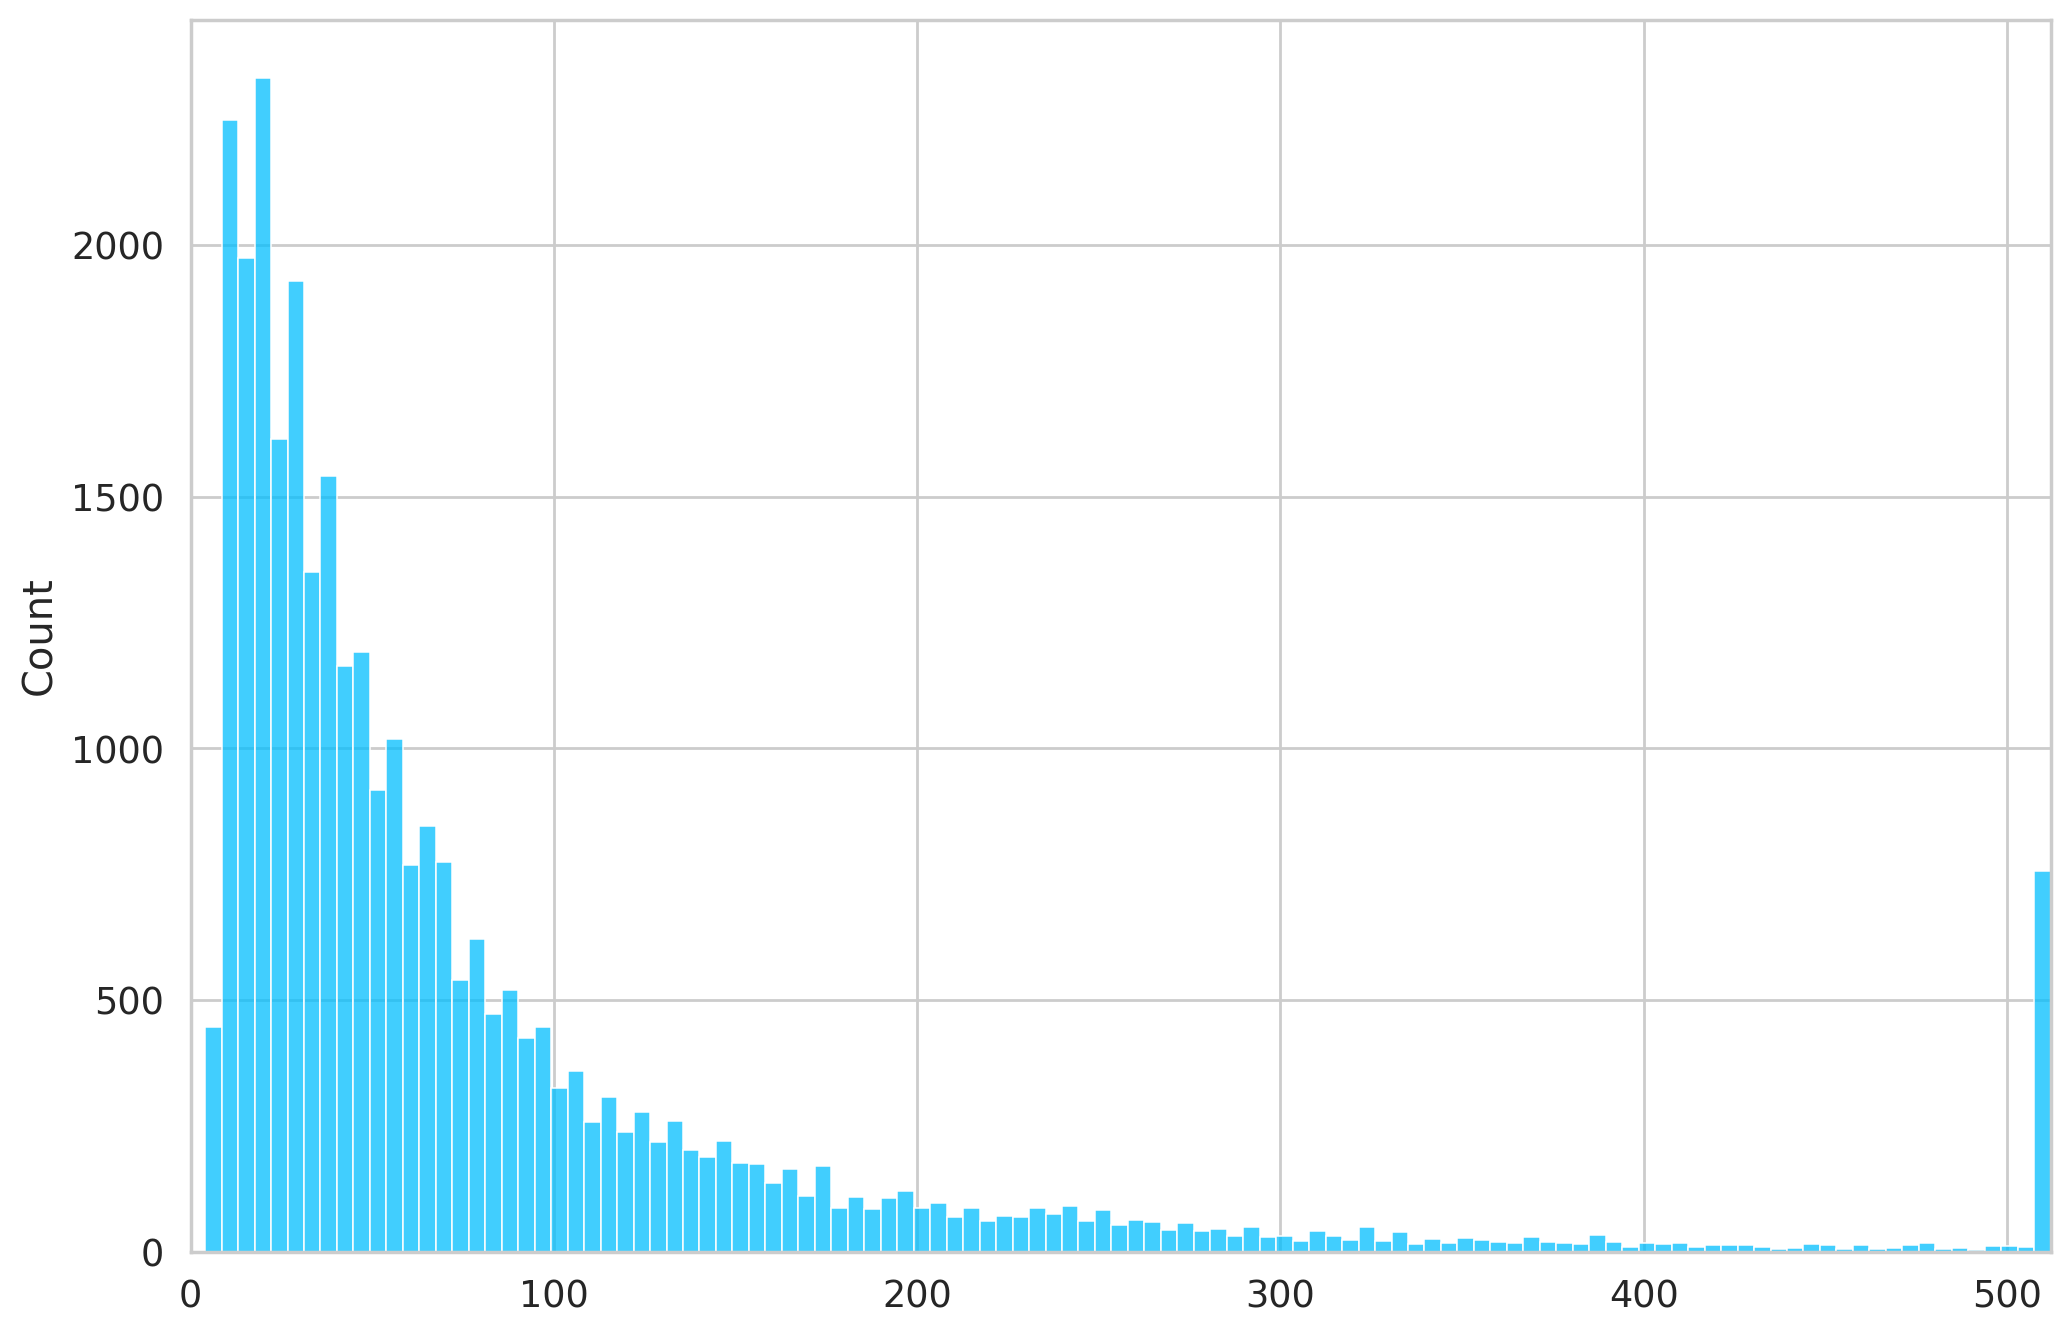

In [18]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [19]:
MAX_TOKEN_COUNT = 512

In [20]:
class ToxicCommentsDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [21]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)


dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [22]:
sample_item["comment_text"]

'You are insulting me and criticizing all of my edits. You are the one who needs to be blocked. From life.'

In [23]:
sample_item["labels"]

tensor([1., 0., 0., 0., 0., 0.])

In [24]:
sample_item["input_ids"].shape

torch.Size([512])

In [25]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as posi

(torch.Size([8, 512]), torch.Size([8, 512]))

In [26]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
output.last_hidden_state.shape, output.pooler_output.shape


(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [27]:
class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [61]:
N_EPOCHS = 2 # 10 change to 2
BATCH_SIZE = 12
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [63]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  # def configure_optimizers(self):
  #   optimizer = AdamW(self.parameters(), lr=2e-5)
  #   scheduler = get_linear_schedule_with_warmup(
  #     optimizer,
  #     num_warmup_steps=self.n_warmup_steps,
  #     num_training_steps=self.n_training_steps
  #   )
  #   return dict(
  #     optimizer=optimizer,
  #     lr_scheduler=dict(
  #       scheduler=scheduler,
  #       interval='step'
  #     )
  #   )
  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-5)
        return [optimizer]

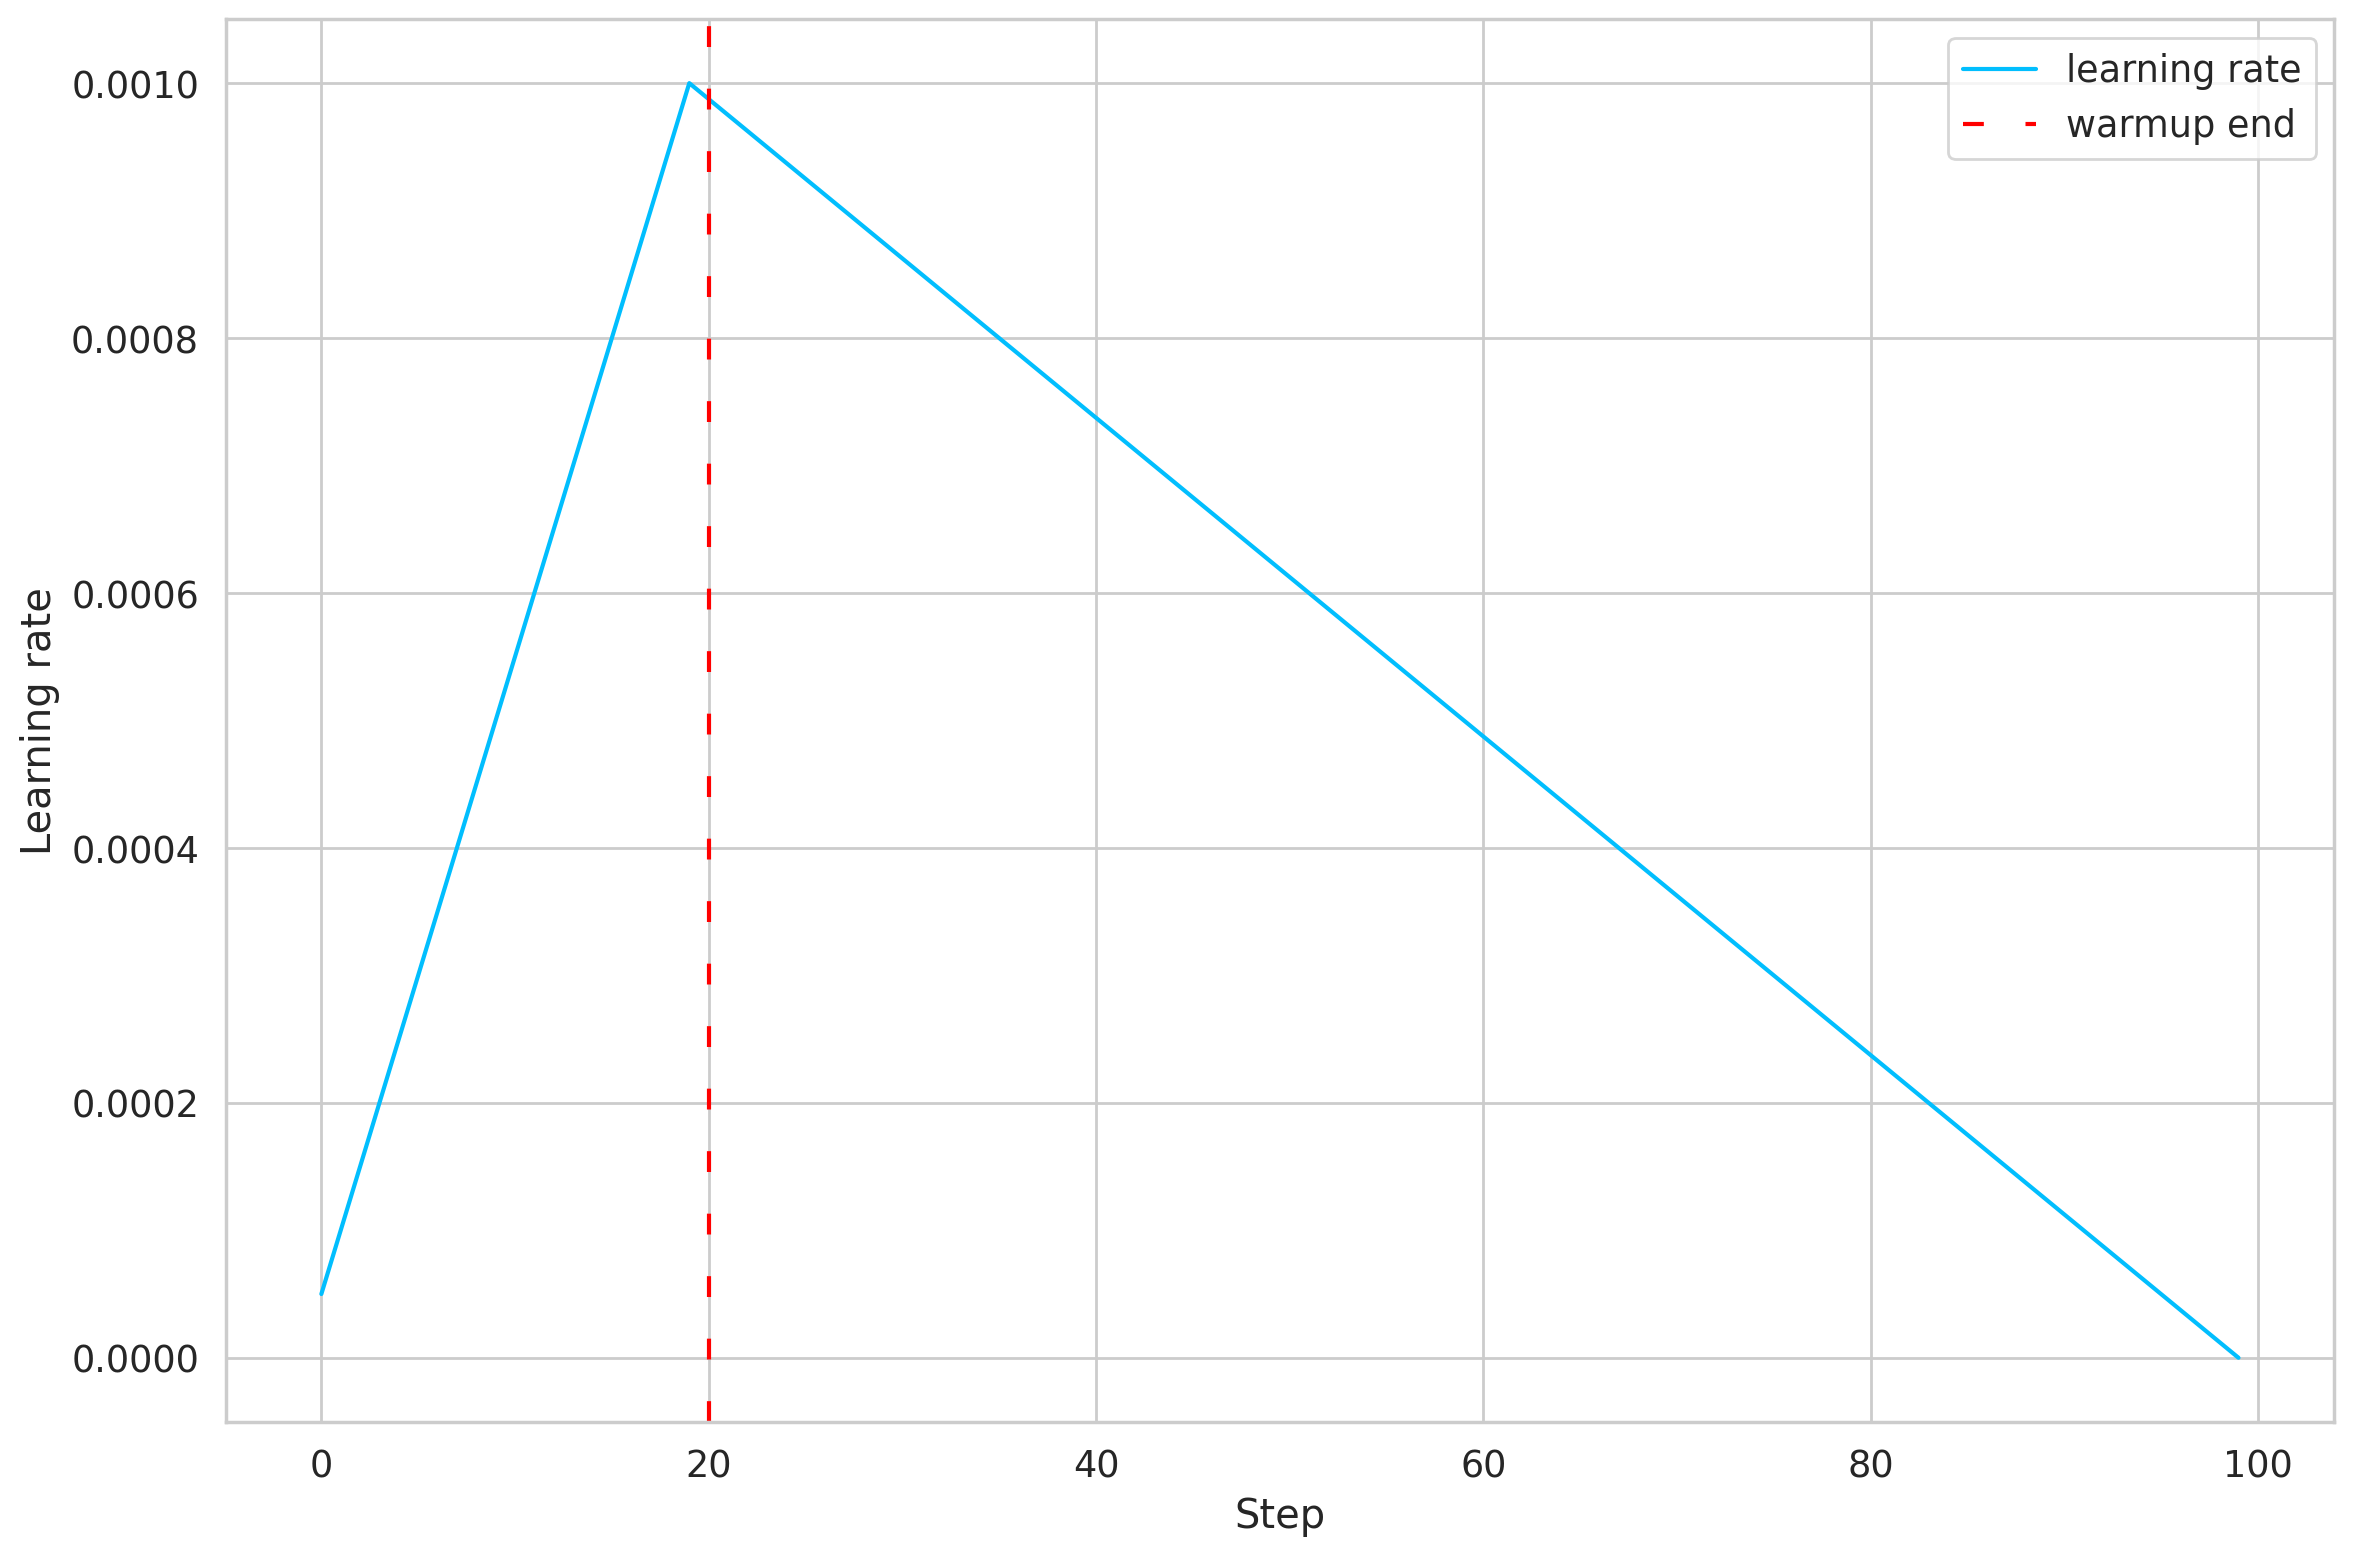

In [64]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [65]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [66]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1012, 5064)

In [67]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

In [68]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)

In [69]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [70]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

In [ ]:
criterion(predictions, sample_batch["labels"])

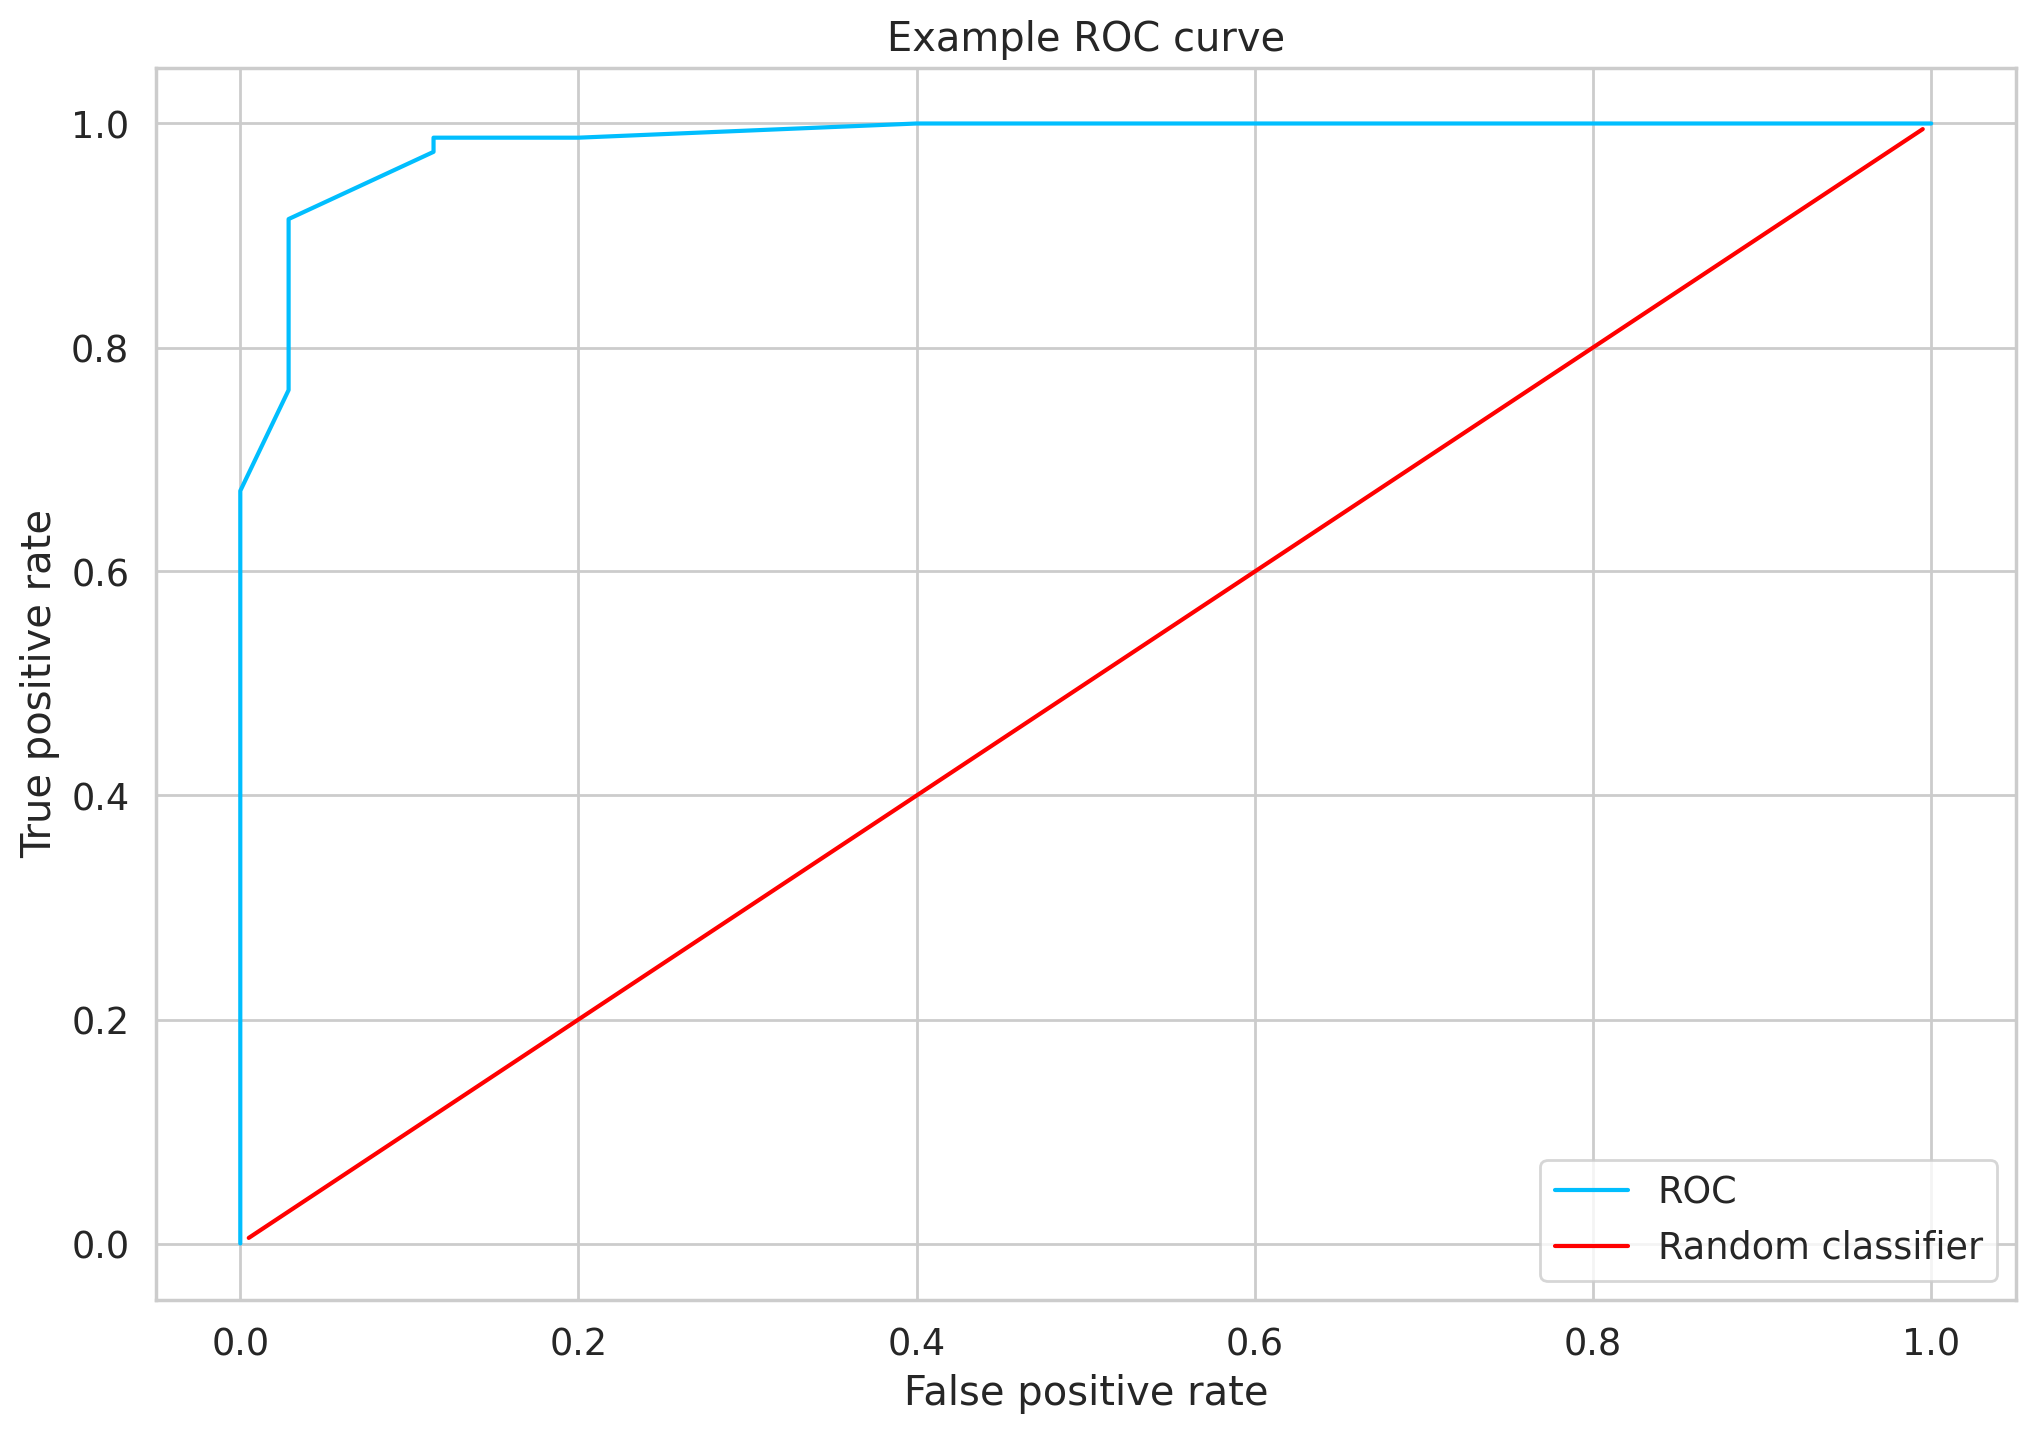

In [55]:
from sklearn import metrics
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

Прелесть PyTorch Lightning в том, что вы можете построить стандартный конвейер, который вам нравится, и обучить (почти?) каждую модель, которую вы можете себе представить. Я предпочитаю использовать не менее 3 компонентов.

Контрольная точка, сохраняющая лучшую модель (на основе потерь при проверке):

In [56]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [57]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [58]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [59]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


In [60]:
trainer.fit(model, data_module)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)
INFO:lightning:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as posi

Training: 0it [00:00, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b6705ede58>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)
<ipython-input-20-49b67

KeyboardInterrupt: 